In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
from depth_anything_3.api import DepthAnything3
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

[WARN ] Dependency `gsplat` is required for rendering 3DGS. Install via: pip install git+https://github.com/nerfstudio-project/gsplat.git@0b4dddf04cb687367602c01196913cde6a743d70


In [2]:
def predict_depth_v2(
    image_source: str | np.ndarray,
    model,
    image_processor,
) -> Image.Image:
    """
    Runs depth estimation on an image and returns a normalized depth map as a PIL Image.

    Args:
        image_source (str): Local image path or URL.
        model: Depth estimation model (e.g. HuggingFace model).
        image_processor: Corresponding image processor.

    Returns:
        PIL.Image.Image: Depth map (uint8, 0–255).
    """

    # Load image (URL or local file) also handle numpy array input
    if isinstance(image_source, str) and image_source.startswith("http"):
        image = Image.open(requests.get(image_source, stream=True).raw)
    if isinstance(image_source, np.ndarray):
        image = Image.fromarray(image_source)
    else:
        image = Image.open(image_source)

    # Prepare image for the model
    inputs = image_processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # Resize prediction back to original image size
    post_processed_output = image_processor.post_process_depth_estimation(
        outputs,
        target_sizes=[(image.height, image.width)],
    )

    predicted_depth = post_processed_output[0]["predicted_depth"]

    # Normalize to 0–255
    depth = (predicted_depth - predicted_depth.min()) / (
        predicted_depth.max() - predicted_depth.min()
    )
    depth = depth.detach().cpu().numpy()
    depth = (depth * 255).astype(np.uint8)

    return Image.fromarray(depth)

In [3]:
device = torch.device("cuda")

model = DepthAnything3.from_pretrained("depth-anything/DA3-BASE")
model = model.to(device=device)

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.10.0+cu128 with CUDA 1208 (you have 2.10.0+cu130)
    Python  3.10.11 (you have 3.10.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


[INFO ] using MLP layer as FFN


In [4]:
image_processor_v2 = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
model_v2 = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")

The image processor of type `DPTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights:   0%|          | 0/287 [00:00<?, ?it/s]

In [34]:
# Test with stereo images
base_path = "../dataset/tree_stereo_image_dataset_v4-Wha0zf/trunks/"
images = [base_path + img for img in ["T01_IMG_20230531_114915_LEFT.jpg", "T01_IMG_20230531_114915_RIGHT.jpg"]]
prediction = model.inference(
    images,
)
# prediction.processed_images : [N, H, W, 3] uint8   array
print(prediction.processed_images.shape)
# prediction.depth            : [N, H, W]    float32 array
print(prediction.depth.shape)  
# prediction.conf             : [N, H, W]    float32 array
print(prediction.conf.shape)  
# prediction.extrinsics       : [N, 3, 4]    float32 array # opencv w2c or colmap format
print(prediction.extrinsics.shape)
# prediction.intrinsics       : [N, 3, 3]    float32 array
print(prediction.intrinsics.shape)

[INFO ] Processed Images Done taking 0.10612010955810547 seconds. Shape:  torch.Size([2, 3, 280, 504])
[INFO ] Model Forward Pass Done. Time: 0.3507664203643799 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010044574737548828 seconds
(2, 280, 504, 3)
(2, 280, 504)
(2, 280, 504)
(2, 3, 4)
(2, 3, 3)


In [35]:
depth_v2 = predict_depth_v2(
    images[0],
    model_v2,
    image_processor_v2,
)

In [36]:
prediction.depth.shape

(2, 280, 504)

<Figure size 1500x1000 with 0 Axes>

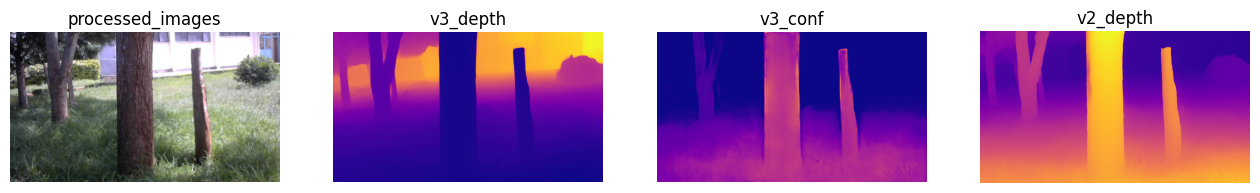

In [47]:
# plt show all depth maps
plt.figure(figsize=(15, 10))
cols  = 4
rows = (int(np.ceil(len(images) / cols)))

showing_depths = {
    "processed_images": prediction.processed_images,
    "v3_depth": prediction.depth,
    "v3_conf": prediction.conf,
    "v2_depth": [depth_v2],
}

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()
for i, (title, data) in enumerate(showing_depths.items()):
    ax = axes[i]
    if title == "processed_images":
        ax.imshow(data[0], cmap="plasma")
    else:
        ax.imshow(data[0], cmap="plasma")
    ax.set_title(title)
    ax.axis("off")


## Depth Anything with SAM masking

In [10]:
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.model_builder import build_sam3_image_model

# Load model & processor
sam_model = build_sam3_image_model()
sam_processor = Sam3Processor(sam_model)

def process_img(img: Image.Image, prompt: str = "a biggest tree"):
    state = sam_processor.set_image(img)
    out = sam_processor.set_text_prompt(prompt, state)
    return out["masks"], out["boxes"], out["scores"]

In [23]:
# load image and mask
img = Image.open(images[0])
masks, boxes, scores = process_img(img, "a biggest tree trunk on the middle")

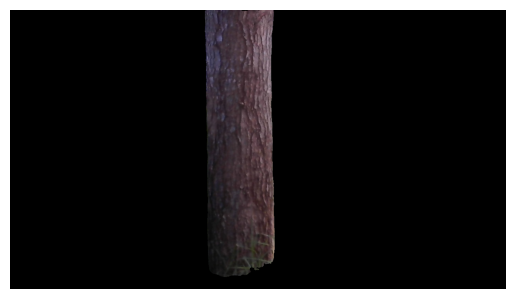

In [24]:
img_np = np.array(img)

# Handle multiple masks
mask_np = masks[0].squeeze(0).cpu().numpy()

masked_img = img_np.copy()
masked_img[~mask_np] = 0

plt.imshow(masked_img)
plt.axis("off")
plt.show()

In [25]:
masked_depth_v2 = predict_depth_v2(
    masked_img,
    model_v2,
    image_processor_v2,
)

In [26]:
masked_img.shape

(720, 1280, 3)

In [27]:
masked_prediction = model.inference(
    [masked_img],
)
# prediction.processed_images : [N, H, W, 3] uint8   array
print(masked_prediction.processed_images.shape)
# prediction.depth            : [N, H, W]    float32 array
print(masked_prediction.depth.shape)  
# prediction.conf             : [N, H, W]    float32 array
print(masked_prediction.conf.shape)  
# prediction.extrinsics       : [N, 3, 4]    float32 array # opencv w2c or colmap format
print(masked_prediction.extrinsics.shape)
# prediction.intrinsics       : [N, 3, 3]    float32 array
print(masked_prediction.intrinsics.shape)

[INFO ] Processed Images Done taking 0.032517433166503906 seconds. Shape:  torch.Size([1, 3, 280, 504])
[INFO ] Model Forward Pass Done. Time: 0.7430384159088135 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0005362033843994141 seconds
(1, 280, 504, 3)
(1, 280, 504)
(1, 280, 504)
(1, 3, 4)
(1, 3, 3)


<Figure size 1500x1000 with 0 Axes>

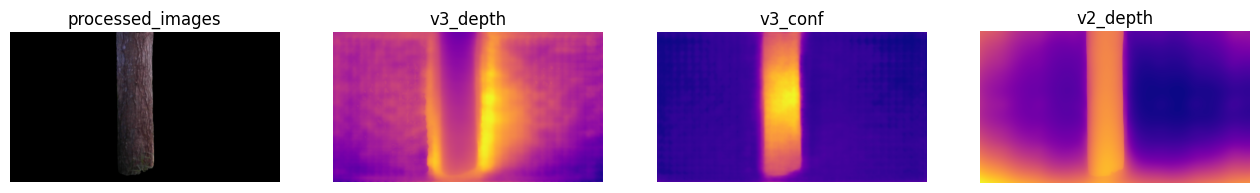

In [28]:
# plt show all depth maps
plt.figure(figsize=(15, 10))
cols  = 4
rows = (int(np.ceil(len(images) / cols)))

showing_depths = {
    "processed_images": masked_prediction.processed_images,
    "v3_depth": masked_prediction.depth,
    "v3_conf": masked_prediction.conf,
    "v2_depth": [masked_depth_v2],
}

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()
for i, (title, data) in enumerate(showing_depths.items()):
    ax = axes[i]
    if title == "processed_images":
        ax.imshow(data[0], cmap="plasma")
    else:
        ax.imshow(data[0], cmap="plasma")
    ax.set_title(title)
    ax.axis("off")


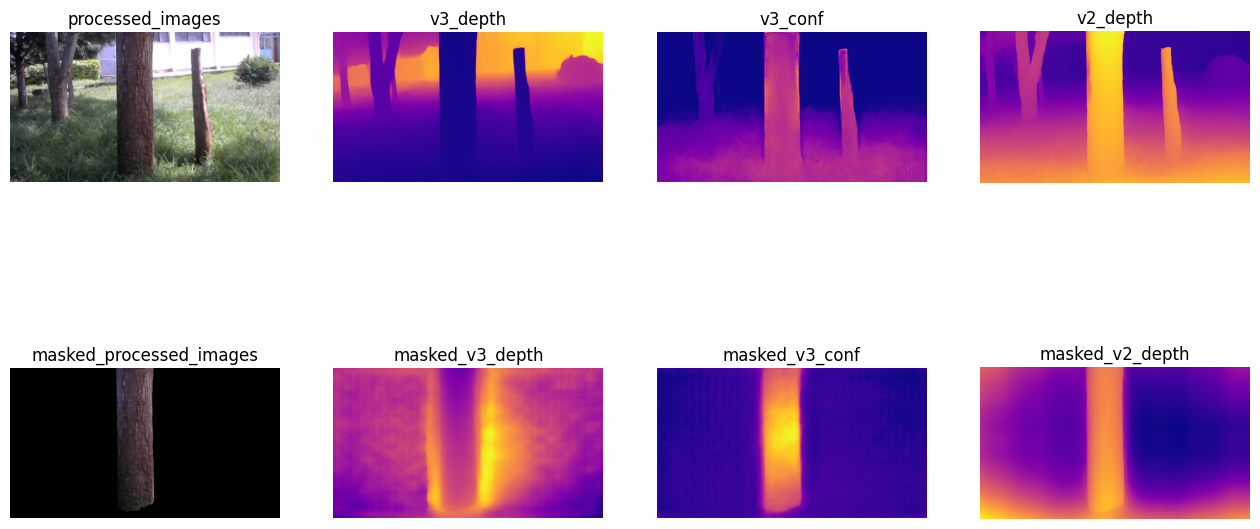

In [29]:
merged_showing_depths = {
    **{
        "processed_images": prediction.processed_images,
        "v3_depth": prediction.depth,
        "v3_conf": prediction.conf,
        "v2_depth": [depth_v2],
    },
    **{
        f"masked_{k}": v
        for k, v in {
            "processed_images": masked_prediction.processed_images,
            "v3_depth": masked_prediction.depth,
            "v3_conf": masked_prediction.conf,
            "v2_depth": [masked_depth_v2],
        }.items()
    }
}


fig, axes = plt.subplots(rows * 2, cols, figsize=(cols * 4, rows * 4 * 2))
axes = axes.flatten()
for i, (title, data) in enumerate(merged_showing_depths.items()):
    ax = axes[i]
    if title == "processed_images":
        ax.imshow(data[0], cmap="plasma")
    else:
        ax.imshow(data[0], cmap="plasma")
    ax.set_title(title)
    ax.axis("off")